# Use spectra of CTIO Data in January 2017 to do atmospheric studies
==================================================================================================

- author : Sylvie Dagoret-Campagne
- date   : January 16th 2017
- update : January 24th 2017


This notebook is supposed to perform an atmospheric properties measurement on spectra




In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from astropy.modeling import models
from astropy import units as u
from astropy import nddata
from astropy.io import fits
import re
import os
import pandas as pd

In [2]:
import ccdproc
print 'ccdproc version',ccdproc.__version__

from astropy.modeling import models

ccdproc version 1.0.1


In [3]:
from scipy import stats  
from scipy import ndimage
from datetime import datetime, timedelta
from mpl_toolkits.mplot3d import Axes3D
import scipy.signal
from scipy.interpolate import interp1d

In [4]:
import bottleneck as bn  # numpy's masked median is slow...really slow (in version 1.8.1 and lower)
print 'bottleneck version',bn.__version__

bottleneck version 1.0.0


In [5]:
import photutils
from astropy.stats import sigma_clipped_stats
from photutils import daofind
from photutils import CircularAperture
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
#from photutils.background import Background2D
from photutils import Background2D, SigmaClip, MedianBackground

In [6]:
%load_ext Cython

In [7]:
from IPython.display import Image, display

In [8]:
import matplotlib
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

In [9]:
from scipy.interpolate import interp1d

In [10]:
import datetime
from dateutil import parser  # very usefull time format smart parser

In [11]:
from matplotlib.dates import MonthLocator, WeekdayLocator,DateFormatter
from matplotlib.dates import MONDAY

In [12]:
mondays = WeekdayLocator(MONDAY)
months = MonthLocator(range(1, 13), bymonthday=1, interval=1)
monthsFmt = DateFormatter("%b '%y")

In [13]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (4, 4),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [14]:
############################################################################
def ensure_dir(f):
    d = os.path.dirname(f)
    if not os.path.exists(f):
        os.makedirs(f)
#########################################################################

In [15]:
inputdir="./spectrum_calibcompsimrealspec"
object_name='HD14943'

In [16]:
outputdir="./spectrum_ana"

In [17]:
ensure_dir(outputdir)

In [18]:
output_file='AnaAtmFromSpectra_'+object_name+'.csv'

## Location of calibrated spectra and Simulations
----------------------------------

In [19]:
input_filelist=os.listdir(inputdir) 

In [20]:
if '.DS_Store' in input_filelist:
    input_filelist.remove('.DS_Store')
input_filelist=np.array(input_filelist)

In [21]:
print input_filelist[0:5]

['compSimRealSpectra_HD14943_20170117_092.fits'
 'compSimRealSpectra_HD14943_20170117_093.fits'
 'compSimRealSpectra_HD14943_20170117_094.fits'
 'compSimRealSpectra_HD14943_20170117_095.fits'
 'compSimRealSpectra_HD14943_20170117_096.fits']


In [22]:
indexes_files= [] # global list
filelist_fitsimages= []  # global list

In [23]:
#%%cython

import numpy as np
import re

def MakeFileList(inputdir,input_filelist):
    """
    MakeFileList : Make The List of files to open
    =============
    """
    
#    import numpy as np
#    import re
    indexes_files= [] # global list
    filelist_fitsimages= []  # global list
    
    for file in input_filelist: # loop on directories, one per image       
            filename=inputdir+'/'+file     
            if re.search('.*fits$',filename):  #example of filename filter
                num_str=re.findall('^compSimRealSpectra_HD14943_20170117_([0-9]+).fits',file)[0]
                index=int(num_str)
                filelist_fitsimages.append(filename)
                indexes_files.append(index)   
                
                
    return indexes_files, filelist_fitsimages

In [24]:
indexes_files, filelist_fitsimages=MakeFileList(inputdir,input_filelist)   # filter to select fits file only

In [25]:
# transform into numpy arrays
indexes_files=np.array(indexes_files)
filelist_fitsimages=np.array(filelist_fitsimages)

In [26]:
print indexes_files

[ 92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163
 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181
 182 183 184 185 186 187 188 189 190 191 192 193 194 195]


In [27]:
sorted_indexes=np.argsort(indexes_files) # sort the file indexes

In [28]:
sorted_numbers=indexes_files[sorted_indexes]

In [29]:
print sorted_indexes

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103]


In [30]:
#sorted_files= [filelist_fitsimages[index] for index in sorted_indexes] # sort files
sorted_files=filelist_fitsimages[sorted_indexes]

In [31]:
sorted_files[0:5]

array([ './spectrum_calibcompsimrealspec/compSimRealSpectra_HD14943_20170117_092.fits',
       './spectrum_calibcompsimrealspec/compSimRealSpectra_HD14943_20170117_093.fits',
       './spectrum_calibcompsimrealspec/compSimRealSpectra_HD14943_20170117_094.fits',
       './spectrum_calibcompsimrealspec/compSimRealSpectra_HD14943_20170117_095.fits',
       './spectrum_calibcompsimrealspec/compSimRealSpectra_HD14943_20170117_096.fits'], 
      dtype='|S76')

## Build full filename
----------------------------

In [32]:
sorted_filenames=[]
for file in sorted_files:
    #fullfilename=os.path.join(inputdir,file)
    fullfilename=file
    sorted_filenames.append(fullfilename)

In [33]:
#sorted_filenames=np.array(sorted_filenames)
sorted_filenames=np.copy(sorted_files)

In [34]:
print sorted_filenames.shape

(104,)


## Acces to spectrum data
----------------------------------

In [35]:
all_dates = []
all_airmass = []
all_spectra = []
all_titles = []
all_header = []
all_img = []

In [36]:
%%cython

import numpy as np
from astropy.io import fits

def BuildCalibSpec(sorted_filenames,sorted_numbers,object_name):
    """
    BuildRawSpec
    ===============
    """

    all_dates = []
    all_airmass = []
    all_leftspectra_data = []
    all_rightspectra_data = []
    all_leftspectra_sim = []
    all_rightspectra_sim = []
    all_leftspectra_wl = []
    all_rightspectra_wl = []
    all_titles = []
    all_header = []
    all_expo = []
   
    NBFILES=sorted_filenames.shape[0]

    for idx in range(NBFILES):  
        
        file=sorted_filenames[idx]    
        
        hdu_list=fits.open(file)
        
        #hdu_list.info()
        
        header=hdu_list[0].header
        #print header
        date_obs = header['DATE-OBS']
        airmass = header['AIRMASS']
        expo = header['EXPTIME']
        num=sorted_numbers[idx]
        title=object_name+" z= {:3.2f} Nb={}".format(float(airmass),num)
        
        # now reads the spectra
        
        table_data=hdu_list[1].data
        
        #cols = hdu_list[1].columns
        #cols.info()
        #print hdu_list[1].columns
        #cols.names
  
        #col1=fits.Column(name='CalibLeftSpecWL',format='E',array=theleftwl_cut[idx[0]])
        #col2=fits.Column(name='CalibLeftSpecData',format='E',array=theleftspectrum_cut[idx[0]])
        #col3=fits.Column(name='CalibLeftSpecSim',format='E',array=theleftsimspec_cut[idx[0]])
        #col4=fits.Column(name='CalibRightSpecWL',format='E',array=therightwl_cut[idx[0]])
        #col5=fits.Column(name='CalibRightSpecData',format='E',array=therightspectrum_cut[idx[0]])
        #col6=fits.Column(name='CalibRightSpecSim',format='E',array=therightsimspec_cut[idx[0]])
    
    
        left_spectrum_wl=table_data.field('CalibLeftSpecWL')
        left_spectrum_data=table_data.field('CalibLeftSpecData')
        left_spectrum_sim=table_data.field('CalibLeftSpecSim')
        
        right_spectrum_wl=table_data.field('CalibRightSpecWL')
        right_spectrum_data=table_data.field('CalibRightSpecData')
        right_spectrum_sim=table_data.field('CalibRightSpecSim')
        
        all_dates.append(date_obs)
        all_airmass.append(float(airmass))
        
        all_leftspectra_data.append(left_spectrum_data)
        all_rightspectra_data.append(right_spectrum_data)
        
        all_leftspectra_wl.append(left_spectrum_wl)
        all_rightspectra_wl.append(right_spectrum_wl)
        
        all_leftspectra_sim.append(left_spectrum_sim)
        all_rightspectra_sim.append(right_spectrum_sim)
        
        all_titles.append(title)
        all_header.append(header)
        all_expo.append(expo)
        hdu_list.close()
        
    return all_dates,all_airmass,all_titles,all_header,all_expo,all_leftspectra_data,all_rightspectra_data,all_leftspectra_sim,all_rightspectra_sim,all_leftspectra_wl, \
        all_rightspectra_wl

In [37]:
all_dates,all_airmass,all_titles,all_header,all_expo,all_leftspectra_data,all_rightspectra_data,all_leftspectra_sim,all_rightspectra_sim,all_leftspectra_wl,all_rightspectra_wl=BuildCalibSpec(sorted_files,sorted_numbers,object_name)

In [38]:
print len(all_dates)

104


## 1.) Show Spectra
==========================

In [39]:
NDATA=len(all_rightspectra_data)

In [40]:
%%cython
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
    
def ShowSpectra(all_spectra,all_ssim,all_wl,all_titles,object_name):
    """
    ShowSpectra: Show the raw images without background subtraction
    ==============
    """
    NBIMAGES=len(all_spectra)
    MAXIMGROW=int(NBIMAGES/5)+1
    thex0 = []
    f, axarr = plt.subplots(MAXIMGROW,5,figsize=(25,60))
    f.tight_layout()
    #plt.subplot_tool() 
    for index in np.arange(0,NBIMAGES):
        ix=index%5
        iy=index/5
        spectrum=all_spectra[index]
        spectrumsim=all_ssim[index]
        wl=all_wl[index]
        axarr[iy,ix].plot(wl,spectrum,'r-',lw=2,label='data')
        axarr[iy,ix].plot(wl,spectrumsim,'b-',lw=2,label='sim')
        axarr[iy,ix].set_title(all_titles[index])
        axarr[iy,ix].set_ylim(0.,3000.)
        axarr[iy,ix].set_xlim(100.,1100.)
        
        axarr[iy,ix].get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
        axarr[iy,ix].get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
        axarr[iy,ix].grid(b=True, which='major', color='k', linewidth=2.0)
        axarr[iy,ix].grid(b=True, which='minor', color='k', linewidth=0.5)
      
        
    
    #title='spectra'
    #plt.suptitle(title,size=16)
   

### Work only on right spectra

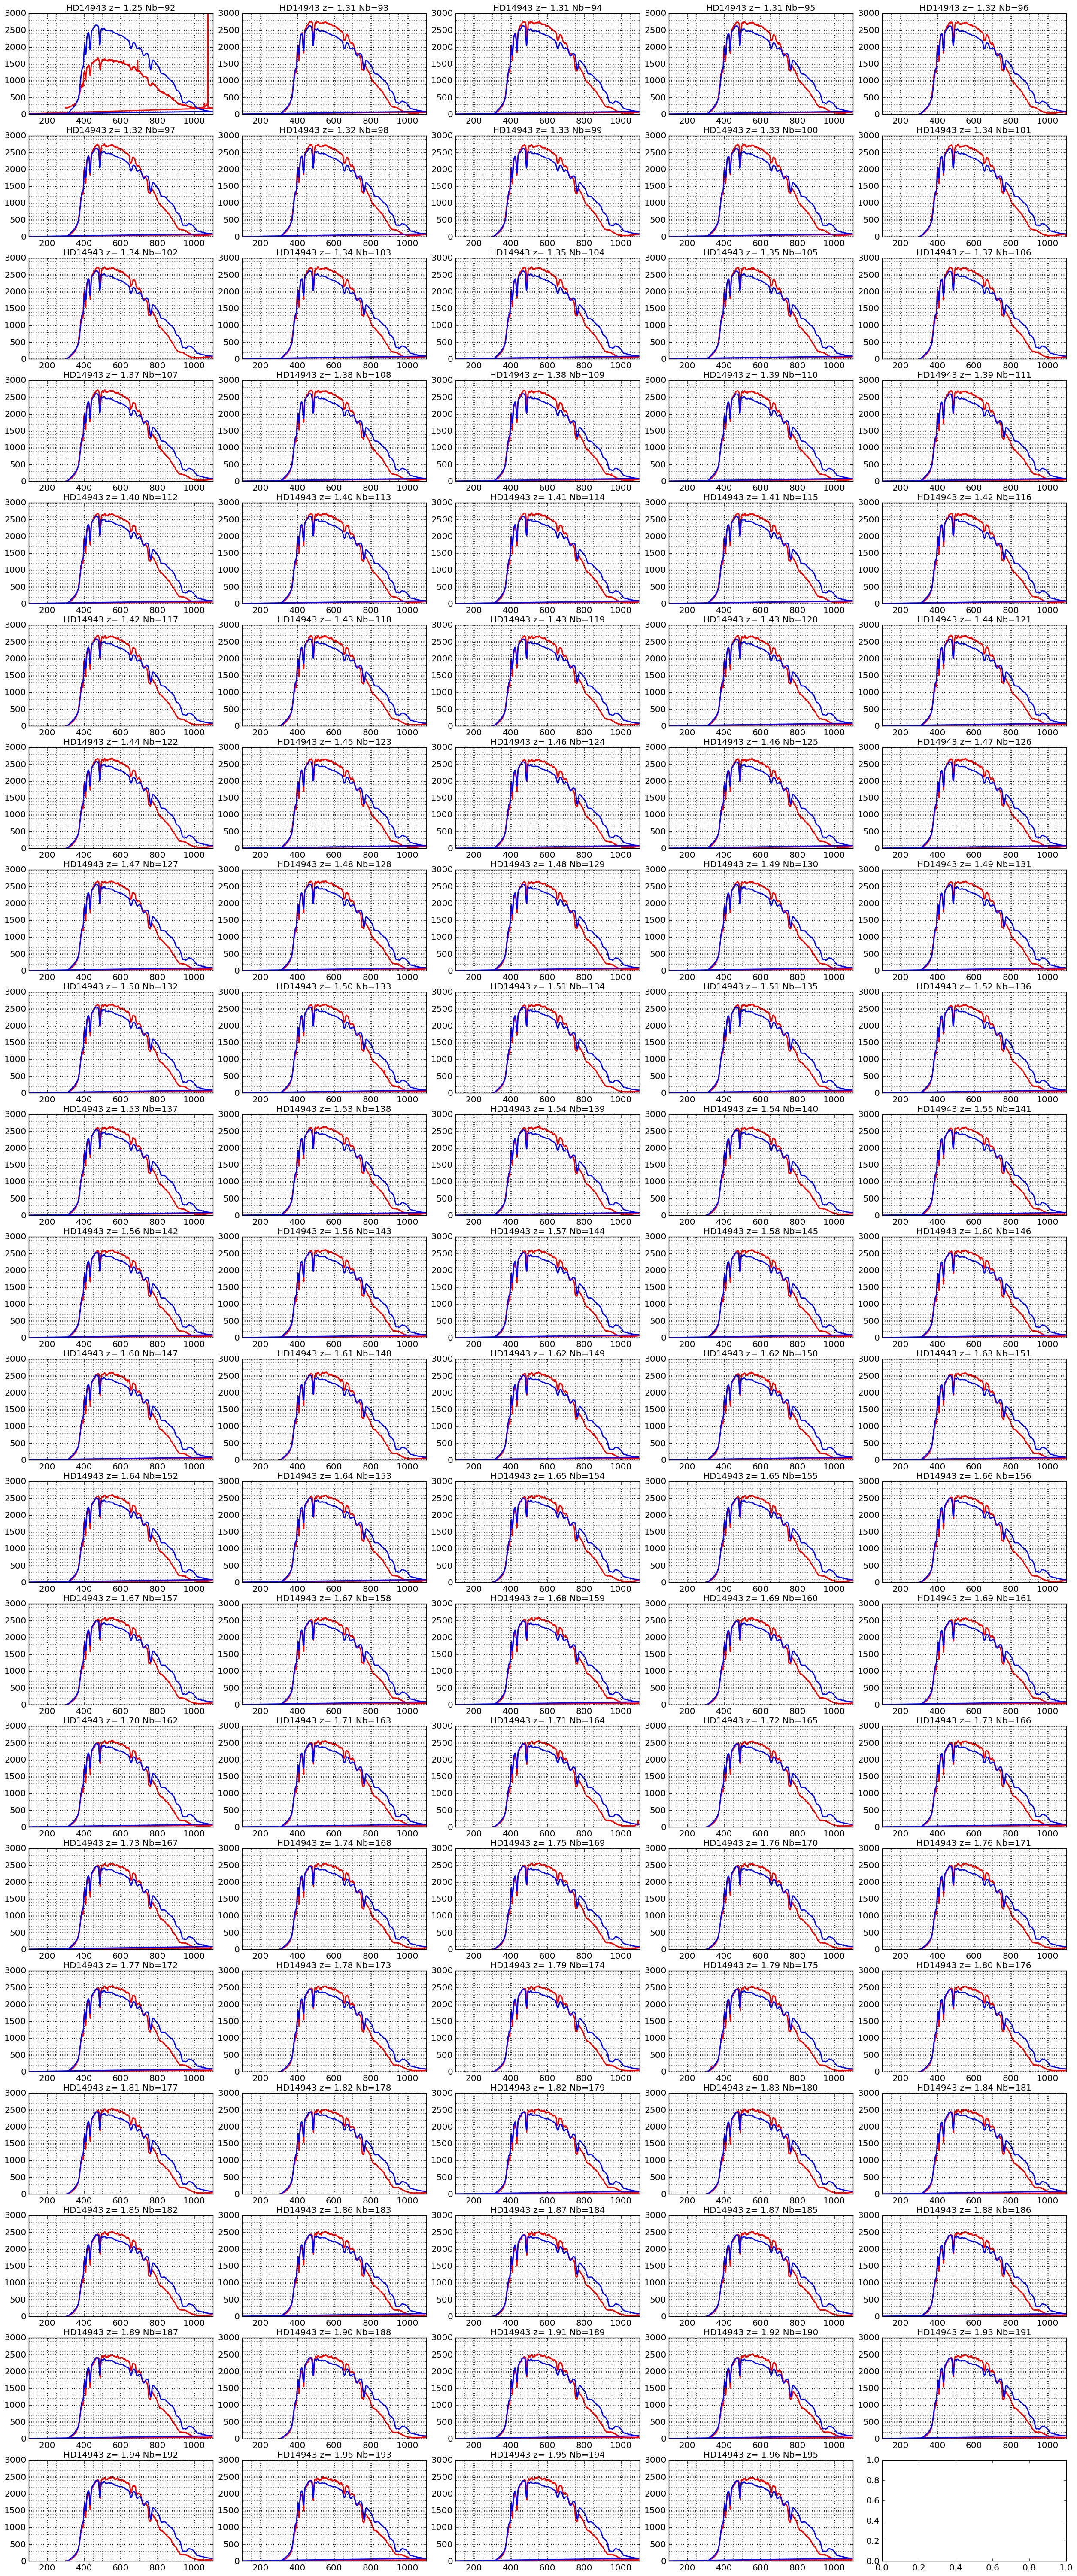

In [41]:
ShowSpectra(all_rightspectra_data,all_rightspectra_sim,all_rightspectra_wl,all_titles,object_name)

In [42]:
wl_O2Aline=759.37      # Balmer Lines
wl_O2Bline=686.719
wl_Haline=656.281 
wl_Hbline=486.134
wl_Hgline=434.047 
wl_Hdline=410.175
wl_Heline=397.0

In [43]:
sel=1
thespectrum=all_rightspectra_data[sel]

In [44]:
thespectrum

array([    8.274436  ,     6.9842658 ,    10.38431168,    10.6423254 ,
          11.02203751,    12.88792801,    13.8293066 ,    16.44363976,
          19.6147213 ,    19.4722538 ,    21.68890953,    27.59956932,
          30.39070892,    36.41940689,    39.0776825 ,    47.9475708 ,
          50.68955994,    54.54956055,    57.33272171,    59.26742172,
          66.77352142,    74.0260849 ,    73.03842926,    82.69158936,
          86.66716766,    95.74450684,    98.22911072,   103.79886627,
         112.22002411,   120.96627045,   127.56482697,   131.01231384,
         138.06112671,   142.0836792 ,   148.23674011,   153.78625488,
         163.68777466,   165.75132751,   177.84649658,   187.96705627,
         194.70619202,   205.51899719,   211.19125366,   221.17204285,
         225.2800293 ,   234.40144348,   243.28511047,   249.42366028,
         264.56848145,   281.68127441,   291.28204346,   310.8404541 ,
         324.33346558,   343.09783936,   359.22659302,   375.38363647,
      

In [45]:
print all_rightspectra_data[sel]

[    8.274436       6.9842658     10.38431168    10.6423254     11.02203751
    12.88792801    13.8293066     16.44363976    19.6147213     19.4722538
    21.68890953    27.59956932    30.39070892    36.41940689    39.0776825
    47.9475708     50.68955994    54.54956055    57.33272171    59.26742172
    66.77352142    74.0260849     73.03842926    82.69158936    86.66716766
    95.74450684    98.22911072   103.79886627   112.22002411   120.96627045
   127.56482697   131.01231384   138.06112671   142.0836792    148.23674011
   153.78625488   163.68777466   165.75132751   177.84649658   187.96705627
   194.70619202   205.51899719   211.19125366   221.17204285   225.2800293
   234.40144348   243.28511047   249.42366028   264.56848145   281.68127441
   291.28204346   310.8404541    324.33346558   343.09783936   359.22659302
   375.38363647   396.17932129   416.36264038   441.224823     478.618927
   503.85247803   548.54437256   590.61376953   642.93560791   703.68121338
   743.74847412  

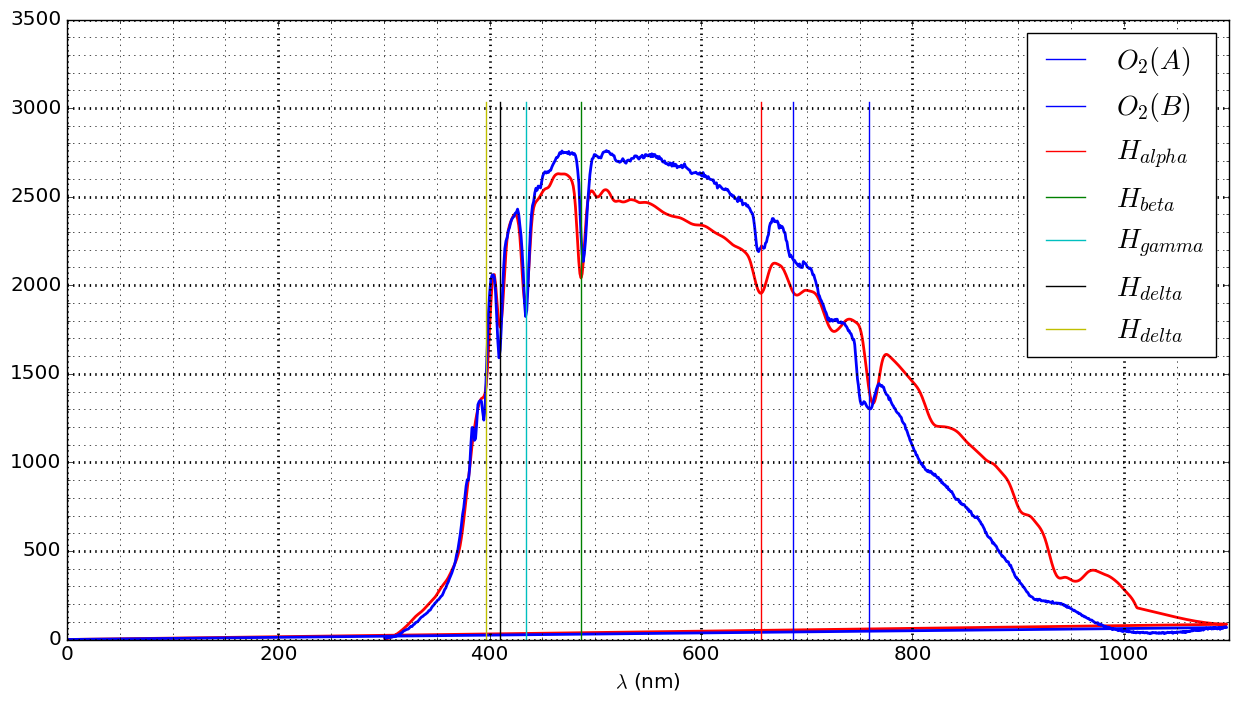

In [46]:
sel=1
thespectrum=all_rightspectra_data[sel]
thesimspectrum=all_rightspectra_sim[sel]

thewl=all_rightspectra_wl[sel]
ymin=thespectrum.min()
ymax=thespectrum.max()*1.1

fig, ax = plt.subplots(1, 1, figsize=(15,8))

ax.plot(thewl,thesimspectrum,'r-',lw=2)
ax.plot(thewl,thespectrum,'b-',lw=2)

ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='k', linewidth=2.0)
ax.grid(b=True, which='minor', color='k', linewidth=0.5)

ax.plot([wl_O2Aline,wl_O2Aline],[ymin,ymax],'b-',label='$O_2(A)$',lw=1)
ax.plot([wl_O2Bline,wl_O2Bline],[ymin,ymax],'b-',label='$O_2(B)$',lw=1)
ax.plot([wl_Haline,wl_Haline],[ymin,ymax],'r-',label='$H_{alpha}$',lw=1)
ax.plot([wl_Hbline,wl_Hbline],[ymin,ymax],'g-',label='$H_{beta}$',lw=1)
ax.plot([wl_Hgline,wl_Hgline],[ymin,ymax],'c-',label='$H_{gamma}$',lw=1)
ax.plot([wl_Hdline,wl_Hdline],[ymin,ymax],'k-',label='$H_{delta}$',lw=1)
ax.plot([wl_Heline,wl_Heline],[ymin,ymax],'y-',label='$H_{delta}$',lw=1)

ax.legend(loc='best',fontsize=20)
ax.set_xlim(0,1100)
ax.set_xlabel("$\lambda$ (nm)")

## 2.) Study ratio Data/Sim spectra
============================================

In [47]:
def ShowRatioSpectra(thewl,thespectrum,thesimspec,all_titles,object_name):
    """
    ShowRatioSpectra: Show the camibration curve
    ==============
    """

    NBSPECTRA=len(thespectrum)
    
    fig, ax = plt.subplots(1, 1, figsize=(15,8))

    all_ymin= []
    all_ymax=[]
    
    for index in np.arange(0,NBSPECTRA):
        ix=index%5
        iy=index/5
                  
        ratio=thespectrum[index]/thesimspec[index]
        all_ymin.append(ratio.min())
        all_ymax.append(ratio.max())
        
        if(all_expo[index] >0 ):
            ax.plot(thewl[index],ratio,'-',lw=2)
       
    ymin=np.array(all_ymin).min() 
    ymax=np.array(all_ymax).max()*1.1   
        
    #ax.set_xlim(0.,1000.)
    ax.set_ylim(0,1.5)
    
    ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.grid(b=True, which='major', color='k', linewidth=2.0)
    ax.grid(b=True, which='minor', color='k', linewidth=0.5)
    
    ax.plot([wl_O2Aline,wl_O2Aline],[ymin,ymax],'b-',label='$O_2(A)$',lw=1)
    ax.plot([wl_O2Bline,wl_O2Bline],[ymin,ymax],'b-',label='$O_2(B)$',lw=1)
    ax.plot([wl_Haline,wl_Haline],[ymin,ymax],'r-',label='$H_{alpha}$',lw=1)
    ax.plot([wl_Hbline,wl_Hbline],[ymin,ymax],'g-',label='$H_{beta}$',lw=1)
    ax.plot([wl_Hgline,wl_Hgline],[ymin,ymax],'c-',label='$H_{gamma}$',lw=1)
    ax.plot([wl_Hdline,wl_Hdline],[ymin,ymax],'k-',label='$H_{delta}$',lw=1)
    ax.legend(loc='best',fontsize=20)
    title='Ratio of Data/Sim spectra for object {}'.format(object_name)
    
    ax.set_title(title)
    ax.set_ylabel("ratio")
    ax.set_xlabel("$\lambda$ (nm)")

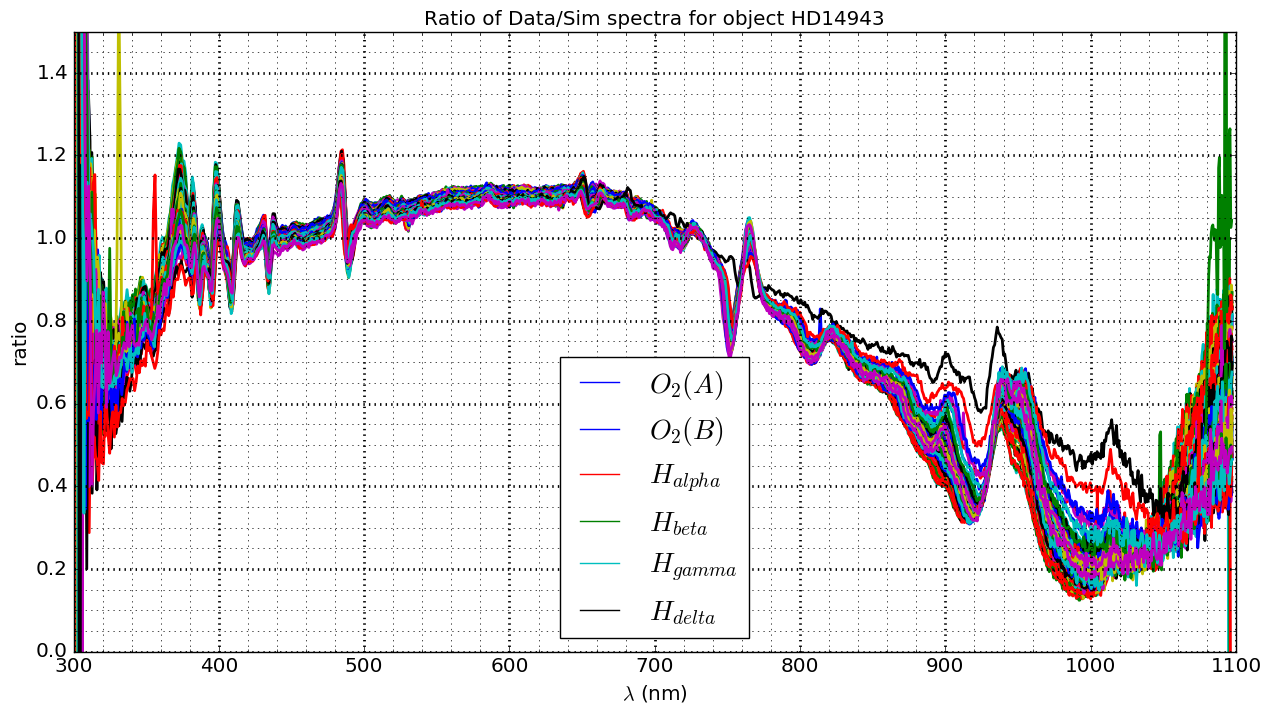

In [48]:
#all_rightspectra_data,all_rightspectra_sim,all_rightspectra_wl,all_titles,object_name
ShowRatioSpectra(all_rightspectra_wl,all_rightspectra_data,all_rightspectra_sim,all_titles,object_name)




In [49]:
wlcut=400

In [50]:
np.where(all_rightspectra_wl[1]>wlcut)

(array([ 87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99,
        100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
        113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
        126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138,
        139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151,
        152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164,
        165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177,
        178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190,
        191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203,
        204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216,
        217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229,
        230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242,
        243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255,
        256, 257, 258, 259, 260, 261, 262, 263, 264

In [51]:
def ShowRatioSpectraSum(thewl,thespectrum,thesimspec,wlcut,all_titles,object_name):
    """
    ShowRatioSpectra: Show the camibration curve
    ==============
    """

    NBSPECTRA=len(thespectrum)
    
    fig, ax = plt.subplots(1, 1, figsize=(15,6))

    all_ymin= []
    all_ymax=[]
    all_sum=[]
    
    for index in np.arange(0,NBSPECTRA):
        ix=index%5
        iy=index/5
         
        selectedindexes=np.where(all_rightspectra_wl[index]>wlcut)    
        sel_data=thespectrum[index][selectedindexes]
        sel_sim=thesimspec[index][selectedindexes]
        sel_wl=all_rightspectra_wl[index][selectedindexes]
        
        ratio=sel_data/sel_sim
        
        if(all_expo[index]>0):
            all_ymin.append(ratio.min())
            all_ymax.append(ratio.max())
            all_sum.append(ratio.mean())
                       
            ax.plot(sel_wl,ratio,'-',lw=2)
       
    ymin=np.array(all_ymin).min() 
    ymax=np.array(all_ymax).max()*1.1   
        
    #ax.set_xlim(0.,1000.)
    ax.set_ylim(0,1.5)
    
    ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.grid(b=True, which='major', color='k', linewidth=2.0)
    ax.grid(b=True, which='minor', color='k', linewidth=0.5)
    
    ax.plot([wl_O2Aline,wl_O2Aline],[ymin,ymax],'b-',label='$O_2(A)$',lw=1)
    ax.plot([wl_O2Bline,wl_O2Bline],[ymin,ymax],'b-',label='$O_2(B)$',lw=1)
    ax.plot([wl_Haline,wl_Haline],[ymin,ymax],'r-',label='$H_{alpha}$',lw=1)
    ax.plot([wl_Hbline,wl_Hbline],[ymin,ymax],'g-',label='$H_{beta}$',lw=1)
    ax.plot([wl_Hgline,wl_Hgline],[ymin,ymax],'c-',label='$H_{gamma}$',lw=1)
    ax.plot([wl_Hdline,wl_Hdline],[ymin,ymax],'k-',label='$H_{delta}$',lw=1)
    ax.legend(loc='best',fontsize=20)
    title='Ratio of Data/Sim spectra for object {}'.format(object_name)
    
    ax.set_title(title)
    ax.set_ylabel("ratio")
    ax.set_xlabel("$\lambda$ (nm)")
    ax.set_xlim(300.,1000.)
    
    fig, ax = plt.subplots(1, 1, figsize=(15,6))
    plt.plot(all_sum,'ro')
    ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.grid(b=True, which='major', color='k', linewidth=2.0)
    ax.grid(b=True, which='minor', color='k', linewidth=0.5)
    title='Average of Ratio of Data/Sim spectra over wavelegth for object {}'.format(object_name)
    
    ax.set_title(title)
    ax.set_ylabel("ratio average ")
    ax.set_xlabel(" image number")
    return np.array(all_sum)

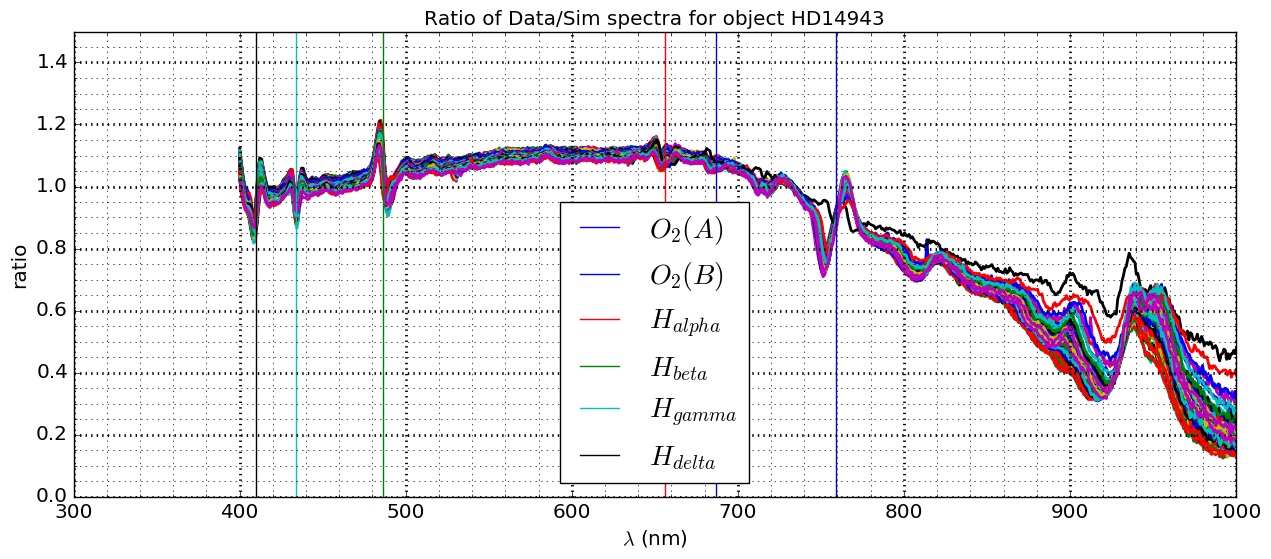

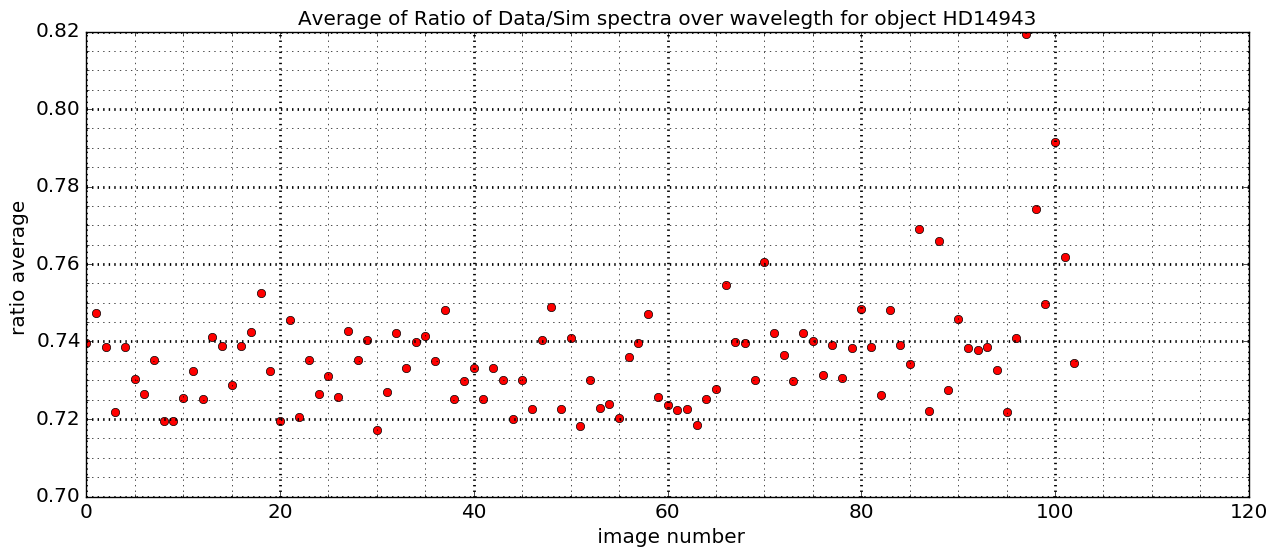

In [52]:
all_ratioaver=ShowRatioSpectraSum(all_rightspectra_wl,all_rightspectra_data,all_rightspectra_sim,wlcut,all_titles,object_name)

In [53]:
np.where(all_expo==0.)

(array([], dtype=int64),)

In [54]:
print all_expo

[0.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 25.154, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0]


In [55]:
all_dt= [ parser.parse(all_dates[i]) for i in range(NDATA)]

## Here remove the crazy first image for that particular date

In [56]:
all_dt.remove(datetime.datetime(2017, 1, 18, 2, 1, 59, 245000))
NDATA-=1

In [80]:
all_airmass

[1.253,
 1.306,
 1.31,
 1.314,
 1.317,
 1.321,
 1.325,
 1.329,
 1.332,
 1.336,
 1.34,
 1.344,
 1.348,
 1.352,
 1.37,
 1.374,
 1.379,
 1.383,
 1.387,
 1.392,
 1.396,
 1.401,
 1.406,
 1.41,
 1.415,
 1.42,
 1.425,
 1.429,
 1.434,
 1.439,
 1.444,
 1.449,
 1.455,
 1.46,
 1.465,
 1.47,
 1.476,
 1.481,
 1.486,
 1.492,
 1.498,
 1.503,
 1.509,
 1.515,
 1.52,
 1.526,
 1.532,
 1.538,
 1.544,
 1.551,
 1.557,
 1.563,
 1.569,
 1.576,
 1.6,
 1.605,
 1.611,
 1.617,
 1.623,
 1.629,
 1.635,
 1.642,
 1.648,
 1.654,
 1.66,
 1.667,
 1.673,
 1.68,
 1.686,
 1.693,
 1.7,
 1.707,
 1.713,
 1.72,
 1.727,
 1.734,
 1.742,
 1.749,
 1.756,
 1.763,
 1.771,
 1.778,
 1.786,
 1.793,
 1.801,
 1.809,
 1.817,
 1.825,
 1.833,
 1.841,
 1.849,
 1.857,
 1.866,
 1.874,
 1.883,
 1.891,
 1.9,
 1.909,
 1.918,
 1.927,
 1.936,
 1.945,
 1.954,
 1.964]

In [57]:
all_dt

[datetime.datetime(2017, 1, 18, 2, 21, 39, 966000),
 datetime.datetime(2017, 1, 18, 2, 22, 53, 476000),
 datetime.datetime(2017, 1, 18, 2, 24, 6, 986000),
 datetime.datetime(2017, 1, 18, 2, 25, 20, 499000),
 datetime.datetime(2017, 1, 18, 2, 26, 34, 11000),
 datetime.datetime(2017, 1, 18, 2, 27, 47, 530000),
 datetime.datetime(2017, 1, 18, 2, 29, 1, 44000),
 datetime.datetime(2017, 1, 18, 2, 30, 14, 556000),
 datetime.datetime(2017, 1, 18, 2, 31, 28, 67000),
 datetime.datetime(2017, 1, 18, 2, 32, 41, 584000),
 datetime.datetime(2017, 1, 18, 2, 33, 55, 106000),
 datetime.datetime(2017, 1, 18, 2, 35, 8, 623000),
 datetime.datetime(2017, 1, 18, 2, 36, 22, 144000),
 datetime.datetime(2017, 1, 18, 2, 41, 34, 869000),
 datetime.datetime(2017, 1, 18, 2, 42, 48, 381000),
 datetime.datetime(2017, 1, 18, 2, 44, 1, 894000),
 datetime.datetime(2017, 1, 18, 2, 45, 15, 411000),
 datetime.datetime(2017, 1, 18, 2, 46, 28, 933000),
 datetime.datetime(2017, 1, 18, 2, 47, 42, 447000),
 datetime.datetime(

In [58]:
import matplotlib.dates as mdates

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
mins=mdates.MinuteLocator()
days=mdates.DayLocator()  # every day
hour=mdates.HourLocator()  # every day
yearsFmt = mdates.DateFormatter('%Y')


In [59]:
am=np.array(all_airmass)*.25

/Users/dagoret-campagnesylvie/.local/lib/python2.7/site-packages/matplotlib/cbook.py:2644: UserWarning: Saw kwargs [u'lw', u'linewidth'] which are all aliases for u'linewidth'.  Kept value from u'linewidth'
  seen=seen, canon=canonical, used=seen[-1]))


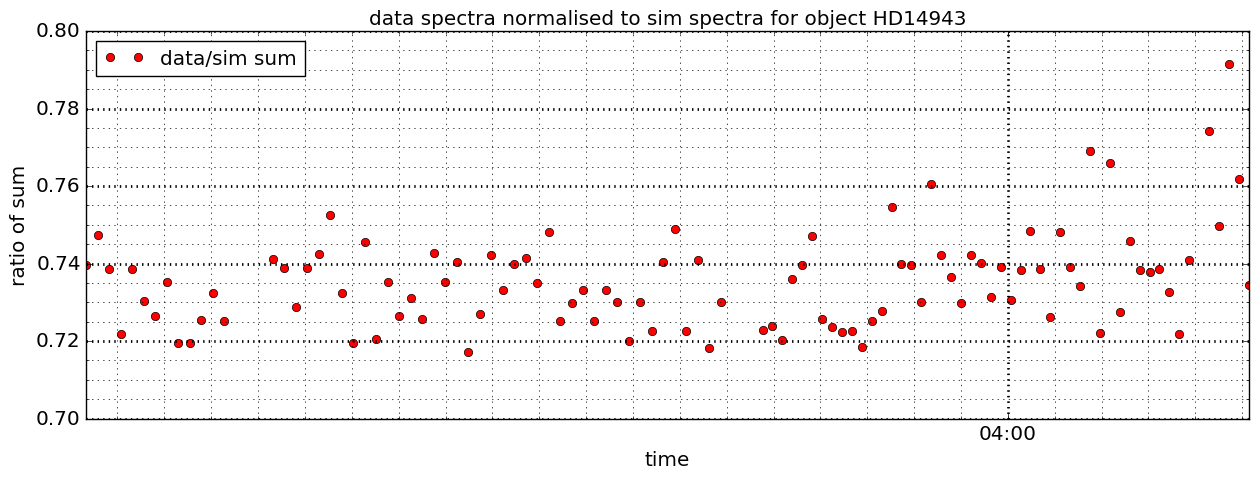

In [60]:
fig=plt.figure(figsize=(15,5))

ax=fig.add_subplot(1,1,1)
ax.plot_date(all_dt, all_ratioaver,marker='o',color='red',lw=0,label='data/sim sum',linewidth=3)
#ax.plot_date(all_dt, am,marker='.',color='blue',lw=0,label='relative airmass',linewidth=3)

ax.set_ylim(0.7,0.8)

date_range = all_dt[NDATA-1] - all_dt[0]

if date_range > datetime.timedelta(days = 1):
    ax.xaxis.set_major_locator(mdates.DayLocator(bymonthday=range(1,32), interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.get_xaxis().set_minor_locator(mdates.HourLocator(byhour=range(0,24,2)))
    #ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
else:
    ax.xaxis.set_major_locator(mdates.HourLocator(byhour=range(0,24,2)))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    #ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_xaxis().set_minor_locator(mdates.MinuteLocator(byminute=range(0,60,5)))
    
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())

ax.grid(b=True, which='major', color='k', linewidth=2.0)
ax.grid(b=True, which='minor', color='k', linewidth=0.5)
ax.set_ylabel('ratio of sum')
ax.set_xlabel('time')


title='data spectra normalised to sim spectra for object {}'.format(object_name)

plt.title(title)
plt.legend(loc='best')

#plt.savefig(figfilename1, bbox_inches='tight')

## 3.) Aerosols : phase 1 : (Data/Sim)(at z) / (Data/Sim)(at zmin)

In [61]:
#all_airmass

In [62]:
#all_airmass.pop(0)

In [63]:
#all_airmass

In [64]:
index_airmassmin=1

In [91]:
def ShowRatioSpectraNorm(idx,thewl,thespectrum,thesimspec,wlcutmin,all_titles,object_name):
    """
    ShowRatioSpectraNorm: Show the calibration curve Normalisation
    ==============
    """

    
    XMIN=400.
    XMAX=740.
    YMINR=0.7
    YMAXR=1.1

    
    NBSPECTRA=len(thespectrum)
    
    fig, ax = plt.subplots(1, 1, figsize=(15,6))
    
    # check the spectrum used for normalisation 
    #---------------------------------------------
    ratio_sel0=thespectrum[idx]/thesimspec[idx]
    interpol_ratio=interp1d(all_rightspectra_wl[idx],ratio_sel0)
    
    #wlcutmax=all_rightspectra_wl[idx].max()-1.
    wlcutmin=XMIN
    wlcutmax=XMAX
    
    selectedindexes0=np.where(np.logical_and(all_rightspectra_wl[idx]>wlcutmin, all_rightspectra_wl[idx]<wlcutmax))     
    
    sel_wl0=all_rightspectra_wl[idx][selectedindexes0]  # cut wl
    
    ax.plot(sel_wl0, interpol_ratio(sel_wl0),'r-')
    ax.grid(True)
    ax.set_xlim(XMIN,XMAX)
    title='Data/Sim spectra ratio at minimum airmass for object {}'.format(object_name)
    
    ax.set_title(title)
    ax.set_ylabel("ratio Data/Sim")
    ax.set_xlabel("$\lambda$ (nm)")
    
    
    # 2nd plot
    #---------
    fig, ax = plt.subplots(1, 1, figsize=(15,8))

    all_ymin= []
    all_ymax=[]
    all_ratioratio=[]
    all_ratiowl=[]
     
    
    for index in np.arange(0,NBSPECTRA):
        
        #print 'spectrum ',index
        ix=index%5
        iy=index/5
        
        
        selectedindexes=np.where(np.logical_and(all_rightspectra_wl[index]>wlcutmin, all_rightspectra_wl[index]<wlcutmax))     
        sel_data=thespectrum[index][selectedindexes]
        sel_sim=thesimspec[index][selectedindexes]
        sel_wl=all_rightspectra_wl[index][selectedindexes]
                
        
        ratio=sel_data/sel_sim
        ratio0=interpol_ratio(sel_wl)
        
        ratioratio=ratio/ratio0
        
        all_ymin.append(ratioratio.min())
        all_ymax.append(ratioratio.max())
        all_ratioratio.append(ratioratio)
        all_ratiowl.append(sel_wl)
           
        if all_expo[index]>0.:    
            ax.plot(sel_wl,ratioratio,'-',lw=2)
       
            ymin=np.array(all_ymin).min() 
            ymax=np.array(all_ymax).max()*1.1   
        
    ax.set_xlim(XMIN,XMAX)
    ax.set_ylim(YMINR,YMAXR)
    
    ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.grid(b=True, which='major', color='k', linewidth=2.0)
    ax.grid(b=True, which='minor', color='k', linewidth=0.5)
    
    ax.plot([wl_O2Aline,wl_O2Aline],[ymin,ymax],'b-',label='$O_2(A)$',lw=1)
    ax.plot([wl_O2Bline,wl_O2Bline],[ymin,ymax],'b-',label='$O_2(B)$',lw=1)
    ax.plot([wl_Haline,wl_Haline],[ymin,ymax],'r-',label='$H_{alpha}$',lw=1)
    ax.plot([wl_Hbline,wl_Hbline],[ymin,ymax],'g-',label='$H_{beta}$',lw=1)
    ax.plot([wl_Hgline,wl_Hgline],[ymin,ymax],'c-',label='$H_{gamma}$',lw=1)
    ax.plot([wl_Hdline,wl_Hdline],[ymin,ymax],'k-',label='$H_{delta}$',lw=1)
    #ax.legend(loc='best',fontsize=20)
    title='Normalised Data/Sim spectra for object {}'.format(object_name)
    
    ax.set_title(title)
    ax.set_ylabel("ratio")
    ax.set_xlabel("$\lambda$ (nm)")
    
    return all_ratiowl,all_ratioratio


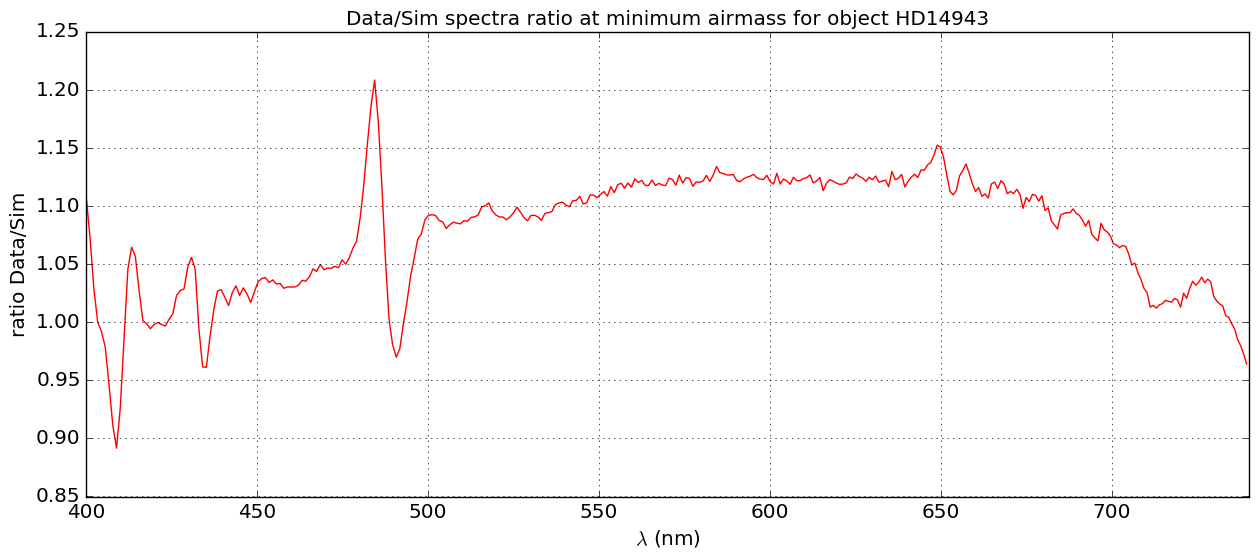

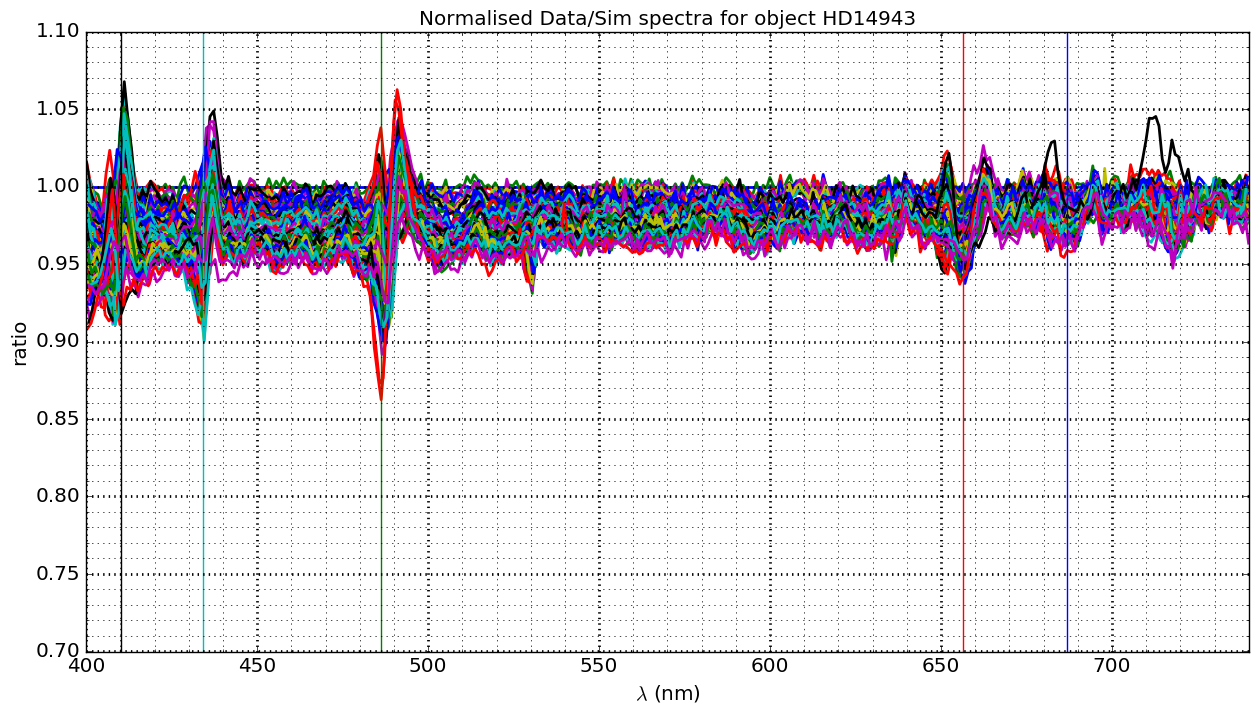

In [92]:
all_ratiowl,all_ratioratio=ShowRatioSpectraNorm(index_airmassmin,all_rightspectra_wl,all_rightspectra_data,all_rightspectra_sim,wlcut,all_titles,object_name)

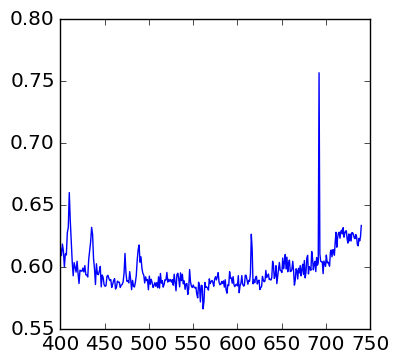

In [93]:
sel=0
plt.plot(all_ratiowl[sel],all_ratioratio[sel],'-')

In [94]:
def FitRatio(all_ratiowl,all_ratioratio,figtitle='Normalised Data/Sim spectra for object {}'):
    NBRATIO=len(all_ratioratio)
    
    XMIN=400.
    XMAX=740.
    YMAX=1.1
    YMIN=0.7
    xfit=np.linspace(XMIN,XMAX,50)
    
    fitparam= []
    
    fig, ax = plt.subplots(1, 1, figsize=(15,8))
    
    for index in np.arange(NBRATIO):
        x=all_ratiowl[index]
        y=all_ratioratio[index]
        z = np.polyfit(x, y, 1)
        fitparam.append(z)
        
        p = np.poly1d(z)
        yfit=p(xfit)
        
        if all_expo[index]>0:    
            ax.plot(xfit,yfit,'-',lw=1)
            
    ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.grid(b=True, which='major', color='k', linewidth=2.0)
    ax.grid(b=True, which='minor', color='k', linewidth=0.5)        
            
    ax.set_ylim(YMIN,YMAX)        
            
    title=figtitle.format(object_name)
    ax.set_title(title)
    ax.set_ylabel("ratio")
    ax.set_xlabel("$\lambda$ (nm)")
    return np.array(fitparam)

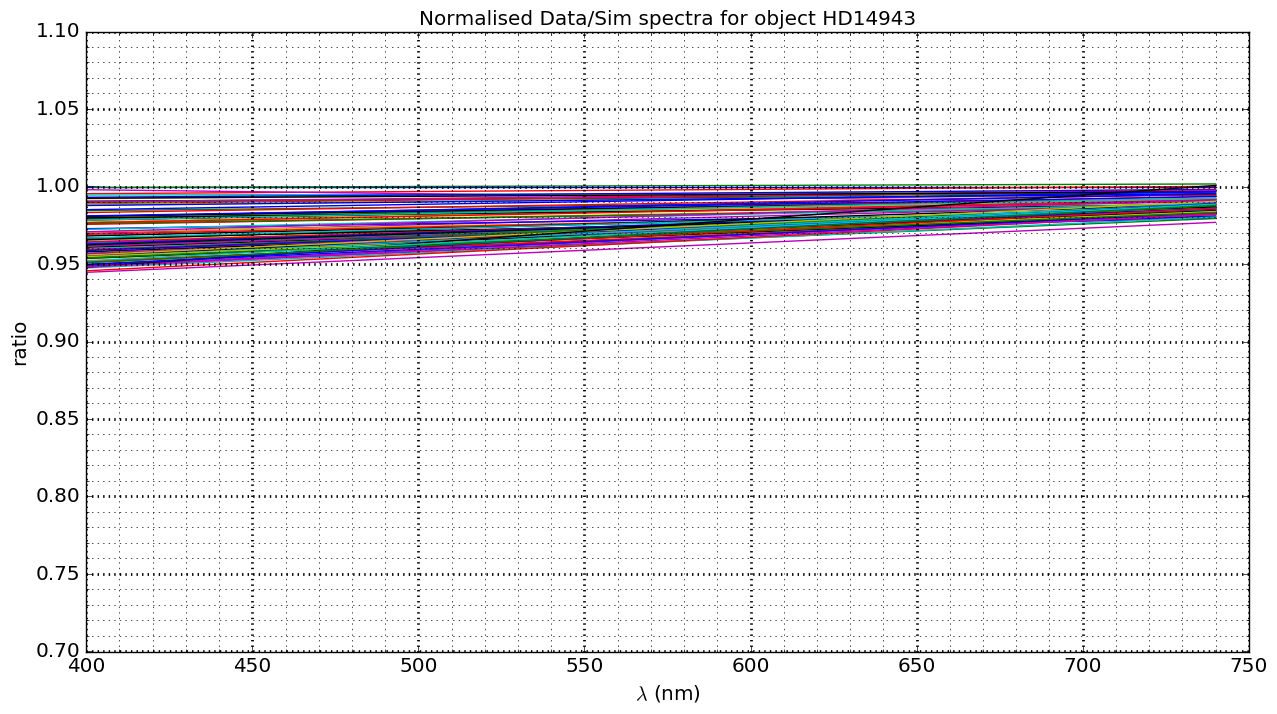

In [95]:
fitparam=FitRatio(all_ratiowl,all_ratioratio)

In [70]:
fitparam[0:5]

array([[  5.27160247e-05,   5.67696324e-01],
       [ -8.18879064e-19,   1.00000000e+00],
       [  6.82525508e-06,   9.96587970e-01],
       [  1.39207948e-05,   9.89787257e-01],
       [  4.09383823e-06,   9.92850885e-01]])

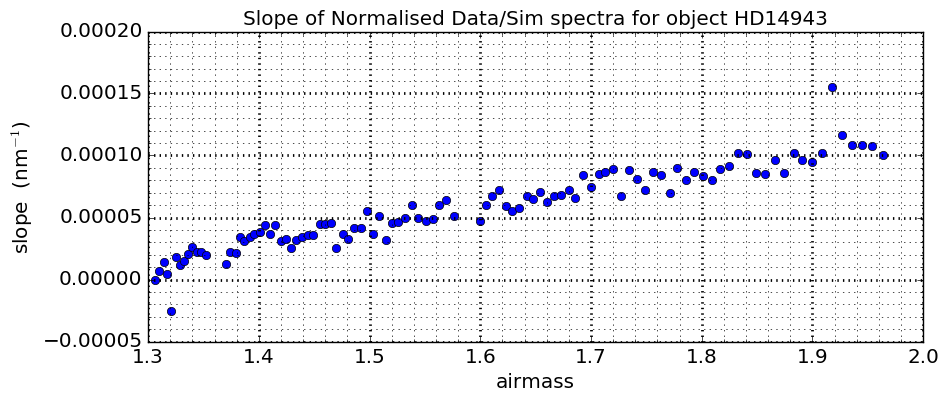

In [99]:
fig, ax = plt.subplots(1, 1, figsize=(10,4))
theX=all_airmass[1:]
theY=fitparam[:,0][1:]
ax.plot(theX,theY,'o')
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='k', linewidth=2.0)
ax.grid(b=True, which='minor', color='k', linewidth=0.5)  

title='Slope of Normalised Data/Sim spectra for object {}'.format(object_name)
ax.set_title(title)
ax.set_ylabel("slope  (nm$^{-1}$)")
ax.set_xlabel("airmass")

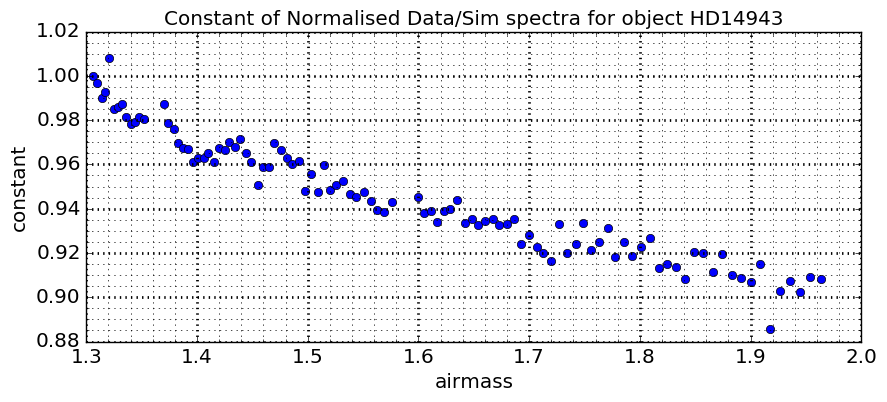

In [100]:
fig, ax = plt.subplots(1, 1, figsize=(10,4))
theX=all_airmass[1:]
theY=fitparam[:,1][1:]
ax.plot(theX,theY,'o')
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='k', linewidth=2.0)
ax.grid(b=True, which='minor', color='k', linewidth=0.5)  

title='Constant of Normalised Data/Sim spectra for object {}'.format(object_name)
ax.set_title(title)
ax.set_ylabel("constant")
ax.set_xlabel("airmass")

## 4.) Aerosols : phase 2 : Data(at z) / (Data)(at zmin)
==================================================================

In [83]:
def ShowRatioSpectraNormNoSim(idx,thewl,thespectrum,wlcutmin,all_titles,object_name):
    """
    ShowRatioSpectraNormNo: Show the calibration curve Normalisation
    ==============
    
    No simulation used here
    """

    
    XMIN=400.
    XMAX=740.
    YMINR=0.7
    YMAXR=1.1
    
    NBSPECTRA=len(thespectrum)
    
    fig, ax = plt.subplots(1, 1, figsize=(15,6))
    
    # check the spectrum used for normalisation 
    #---------------------------------------------
    # The spectrum at zmin
    specnorm_sel0=thespectrum[idx]
    interpol_spec0=interp1d(all_rightspectra_wl[idx],specnorm_sel0)  # interpolation of selected spectrum
    
   
    wlcutmin=XMIN
    wlcutmax=XMAX
    
    selectedindexes0=np.where(np.logical_and(all_rightspectra_wl[idx]>wlcutmin, all_rightspectra_wl[idx]<wlcutmax))      
    sel_wl0=all_rightspectra_wl[idx][selectedindexes0]  # cut wl
    
    ax.plot(sel_wl0, interpol_spec0(sel_wl0),'r-')
    ax.grid(True)
    ax.set_xlim(XMIN,XMAX)
    title='Data(zmin) spectra ratio at minimum airmass for object {}'.format(object_name)
    
    ax.set_title(title)
    ax.set_ylabel("Data(zmin)")
    ax.set_xlabel("$\lambda$ (nm)")
    
    
    # 2nd plot
    #---------
    fig, ax = plt.subplots(1, 1, figsize=(15,8))

    all_ymin= []
    all_ymax=[]
    all_ratio=[]
    all_ratiowl=[]
     
    ## loop on all sectra
    for index in np.arange(0,NBSPECTRA):
        
        #print 'spectrum ',index
        ix=index%5
        iy=index/5
        
        
        selectedindexes=np.where(np.logical_and(all_rightspectra_wl[index]>wlcutmin, all_rightspectra_wl[index]<wlcutmax))     
        sel_data=thespectrum[index][selectedindexes]
        
        sel_wl=all_rightspectra_wl[index][selectedindexes]
                
        
        spec0=interpol_spec0(sel_wl)
        
        ratio=sel_data/spec0
        
        all_ymin.append(ratio.min())
        all_ymax.append(ratio.max())
        all_ratio.append(ratio)
        all_ratiowl.append(sel_wl)
           
        if all_expo[index]>0.:    
            ax.plot(sel_wl,ratio,'-',lw=2)
       
            ymin=np.array(all_ymin).min() 
            ymax=np.array(all_ymax).max()*1.1   
        
    ax.set_xlim(XMIN,XMAX)
    ax.set_ylim(YMINR,YMAXR)
    
    ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.grid(b=True, which='major', color='k', linewidth=2.0)
    ax.grid(b=True, which='minor', color='k', linewidth=0.5)
    
    ax.plot([wl_O2Aline,wl_O2Aline],[ymin,ymax],'b-',label='$O_2(A)$',lw=1)
    ax.plot([wl_O2Bline,wl_O2Bline],[ymin,ymax],'b-',label='$O_2(B)$',lw=1)
    ax.plot([wl_Haline,wl_Haline],[ymin,ymax],'r-',label='$H_{alpha}$',lw=1)
    ax.plot([wl_Hbline,wl_Hbline],[ymin,ymax],'g-',label='$H_{beta}$',lw=1)
    ax.plot([wl_Hgline,wl_Hgline],[ymin,ymax],'c-',label='$H_{gamma}$',lw=1)
    ax.plot([wl_Hdline,wl_Hdline],[ymin,ymax],'k-',label='$H_{delta}$',lw=1)
    #ax.legend(loc='best',fontsize=20)
    title='Normalised Data/Data(zmin) spectra for object {}'.format(object_name)
    
    ax.set_title(title)
    ax.set_ylabel("ratio")
    ax.set_xlabel("$\lambda$ (nm)")
    
    return all_ratiowl,all_ratio



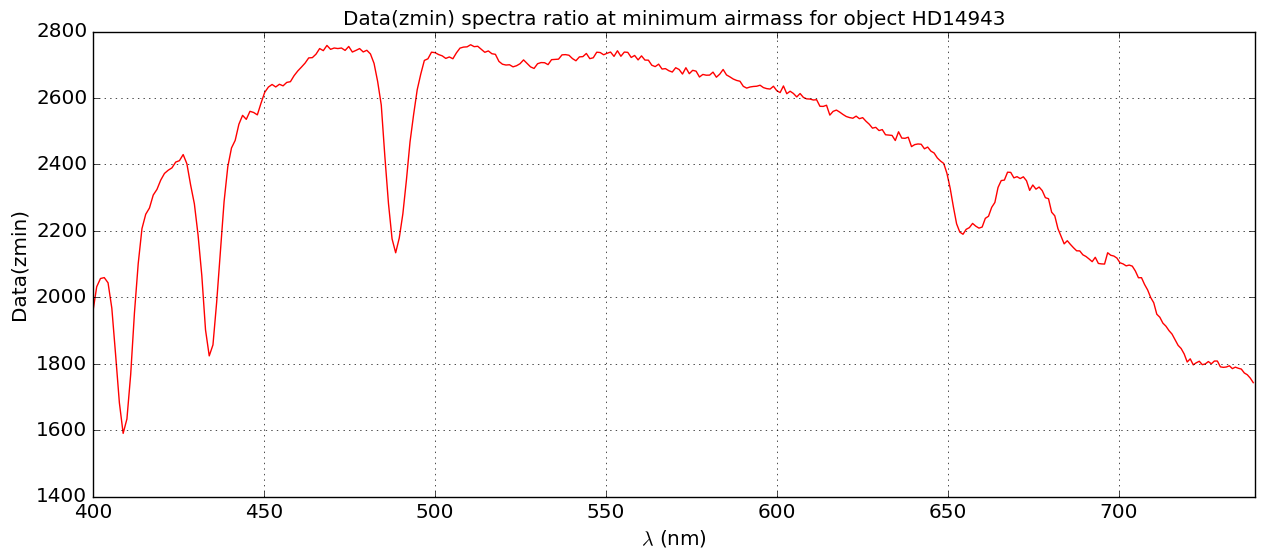

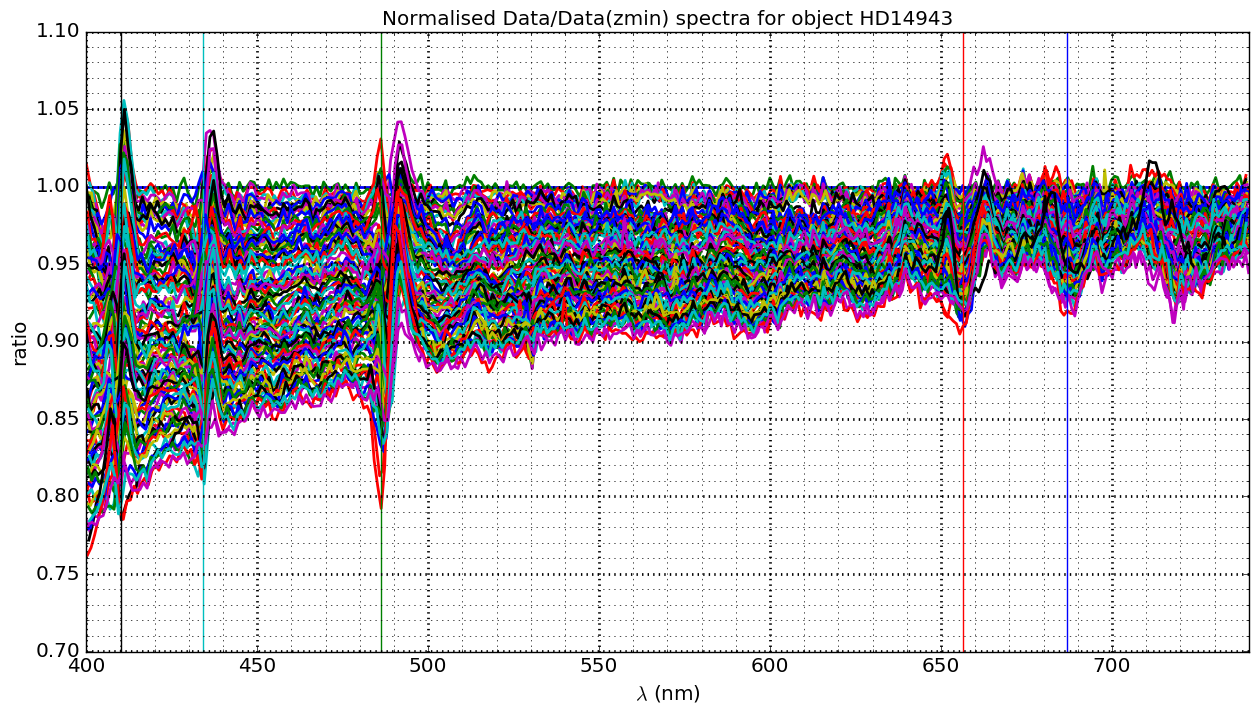

In [98]:
all_ratiowl,all_ratiobyzmin=ShowRatioSpectraNormNoSim(index_airmassmin,all_rightspectra_wl,all_rightspectra_data,wlcut,all_titles,object_name)

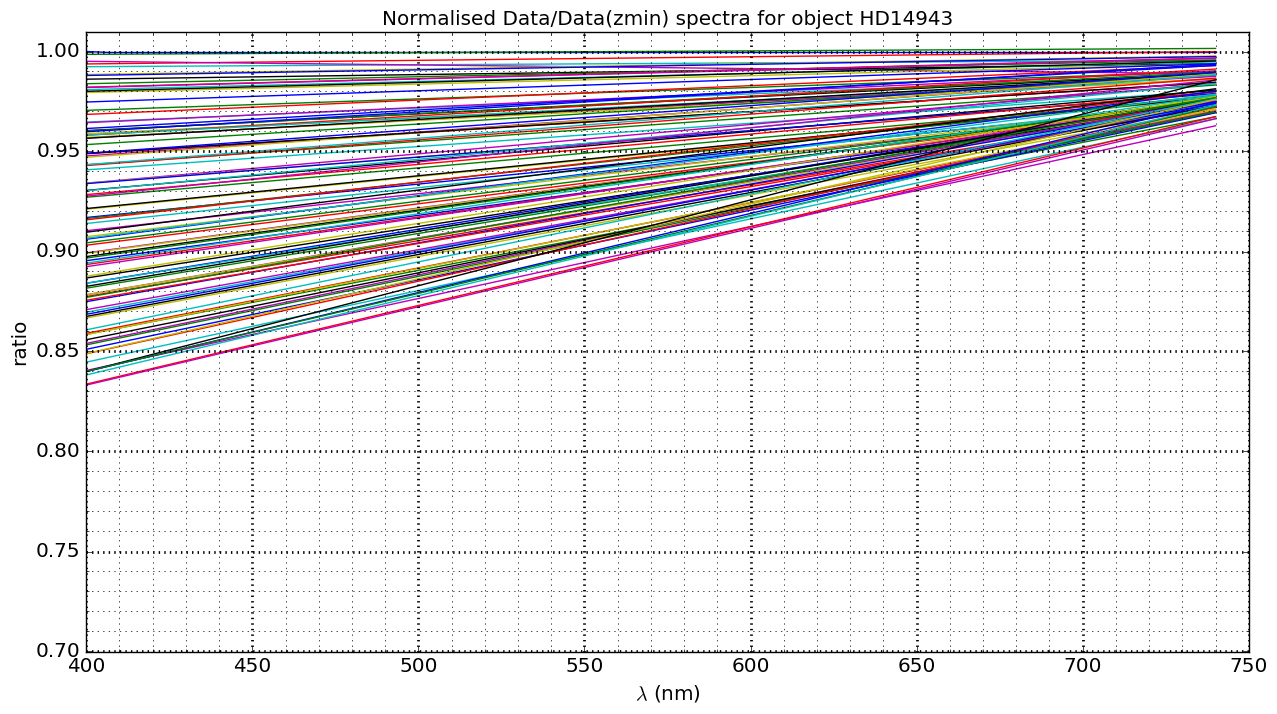

In [88]:
fitparam2=FitRatio(all_ratiowl,all_ratiobyzmin,figtitle='Normalised Data/Data(zmin) spectra for object {}')

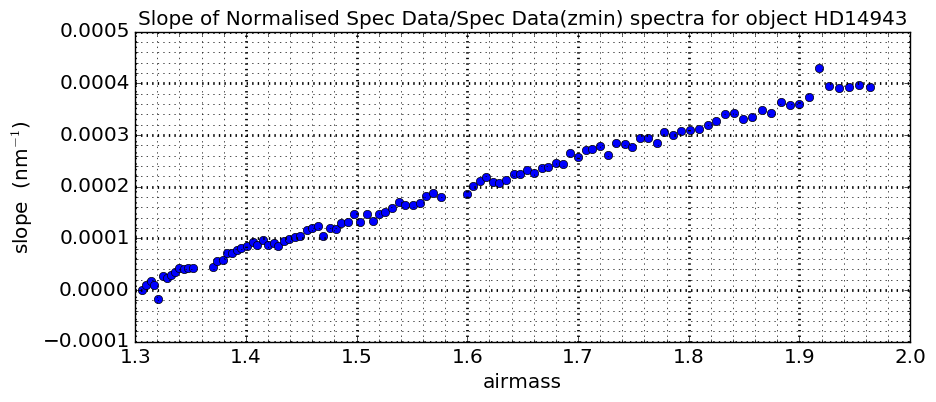

In [81]:
fig, ax = plt.subplots(1, 1, figsize=(10,4))
theX=all_airmass[1:]
theY=fitparam2[:,0][1:]
ax.plot(theX,theY,'o')
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='k', linewidth=2.0)
ax.grid(b=True, which='minor', color='k', linewidth=0.5)  

title='Slope of Normalised Spec Data/Spec Data(zmin) spectra for object {}'.format(object_name)
ax.set_title(title)
ax.set_ylabel("slope  (nm$^{-1}$)")
ax.set_xlabel("airmass")

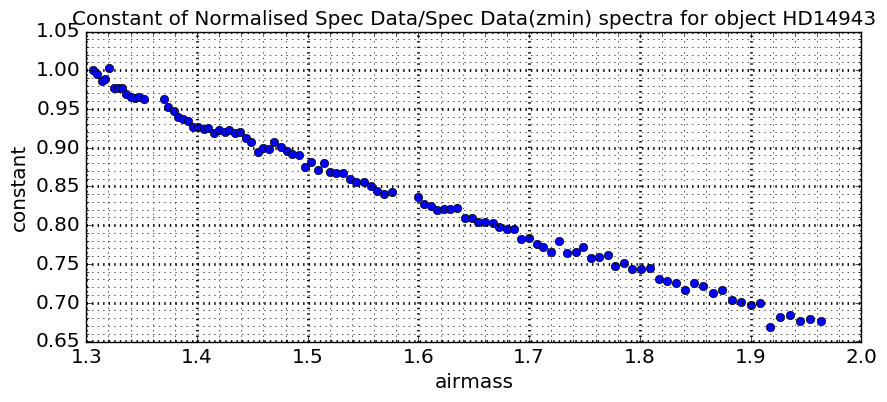

In [82]:
fig, ax = plt.subplots(1, 1, figsize=(10,4))
theX=all_airmass[1:]
theY=fitparam2[:,1][1:]
ax.plot(theX,theY,'o')
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='k', linewidth=2.0)
ax.grid(b=True, which='minor', color='k', linewidth=0.5)  

title='Constant of Normalised Spec Data/Spec Data(zmin) spectra for object {}'.format(object_name)
ax.set_title(title)
ax.set_ylabel("constant")
ax.set_xlabel("airmass")